# Пример использования простых методов векторизации на Python

Векторизуем тексты отзывов на банки с сайта banki.ru.


#Задания

##Задание 1
На основе подсчета частоты слов в корпусе проверьте выполнение закона Ципфа путем построения графика зависимости частоты слова от ранга.

##Задание 2
Посмотрите, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud). Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.
Исправьте приведенный пример для представления Bag of Words (Мешок слов).
* Создайте словарь частот слов с помощью collections.Counter
* Нарисуйте облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()
* Используйте nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова

##Задание 3
Постройте векторное представление текстов корпуса на основе метода TF*IDF (TfidfVectorizer). Используйте это представление текстов для обучения классификатора. Сравните его работу по сравнению с классификатором, использоваавшем модель Bag of Words (Мешка слов).


In [ ]:
!pip install pymorphy2[fast] 

In [2]:
import pandas as pd
import numpy as np
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Загружаем и готовим набор данных

Загружаем файл с dropbox

In [4]:
!wget https://www.dropbox.com/s/a9r0b2yj3vqvi13/banks.csv?dl=1 -O banks.csv

--2023-03-30 09:59:16--  https://www.dropbox.com/s/a9r0b2yj3vqvi13/banks.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/a9r0b2yj3vqvi13/banks.csv [following]
--2023-03-30 09:59:17--  https://www.dropbox.com/s/dl/a9r0b2yj3vqvi13/banks.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7cb79a9ef56b613f014c5b82b2.dl.dropboxusercontent.com/cd/0/get/B5M7p6k_EiuylWOlmJWLn0BhhtSQkk8xXsf4hzoseP_vsnNYNHvCvwzDRTfnmuiv3R_1ZbiifrJI2yIfp1C-JKrPyzxO73oE1BLnIqDayY8tWYPeCHIL1IpC1DGI7lS9zhOwcCXxsUu-YF8TCEWajow_7nTEiD-DbExovtf-64PALw/file?dl=1# [following]
--2023-03-30 09:59:18--  https://uc7cb79a9ef56b613f014c5b82b2.dl.dropboxusercontent.com/cd/0/get/B5M7p6k_EiuylWOlmJWLn0BhhtSQkk8xXsf4hzoseP_vsnNYNHvCvwzDRTfnmuiv3R_1ZbiifrJI2yIfp1C-

In [5]:
path=''

Или загружаем файл со своего google-диска (код надо раскомментировать)



In [ ]:
# Подключаем Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Путь каталогу с данными на Google Drive
path = "drive/MyDrive/colab_data/"

MessageError: ignored

In [11]:
banks = pd.read_csv(path+'banks.csv', sep='\t', index_col='idx');

Выполняем предобработку текстов

In [12]:
def preprocess(text, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return preprocessed_text

In [13]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', '...', '«', '»', ';', '–', '--']
stop_words = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

In [14]:
banks['Preprocessed_texts'] = banks.apply(lambda row: preprocess(row['Text'], punctuation_marks, stop_words, morph), axis=1)

In [15]:
banks

Score                                               Text  \
idx                                                                  
0      Positive  В Альфа-Банке работает замечательная девушка -...   
1      Negative  Оформляя рассрочку в м. Видео в меге тёплый ст...   
2      Positive  Очень порадовала оперативность работы в банке....   
3      Negative  Имела неосторожность оформить потреб. кредит в...   
4      Negative  Небольшая предыстория: Нашел на сайте MDM банк...   
...         ...                                                ...   
13994  Positive  О высокой надёжности МКБ, порядочности и добро...   
13995  Positive  Обслуживаюсь в офисе на Чернореченской 42а, ка...   
13996  Positive  Попала сегодня в очень неприятную ситуацию. Ре...   
13997  Positive  Добрый день! Давно являюсь клиентом банка Русс...   
13998  Negative  Сначала было все банально. Взял в кредит mp3 п...   

                                      Preprocessed_texts  
idx                                                       
0      [альфа-банк, работать, замечательный, девушка,...  
1      [оформлять, рассрочка, м., видео, мег, тёплый,...  
2      [очень, порадовать, оперативность, работа, бан...  
3      [иметь, неосторожность, оформить, потреба, кре...  
4      [небольшой, предыстория, найти, сайт, mdm, бан...  
...                                                  ...  
13994  [высокий, надёжность, мкб, порядочность, добро...  
13995  [обслуживаться, офис, чернореченский, 42а, физ...  
13996  [попасть, сегодня, очень, неприятный, ситуация...  
13997  [добрый, день, давно, являться, клиент, банк, ...  
13998  [сначала, банально, взять, кредит, mp3, плеер,...  

[13999 rows x 3 columns]

## Определяем частоту слов

In [16]:
from collections import Counter

Тестируем работу Counter

In [17]:
test_counter = Counter(banks['Preprocessed_texts'][0])

In [18]:
test_counter

Counter({'альфа-банк': 2,
         'работать': 1,
         'замечательный': 2,
         'девушка': 2,
         'ильясова': 2,
         'орный': 2,
         'вежливый': 1,
         'отзывчивый': 1,
         'действительно': 1,
         'участвовать': 1,
         'запрос': 1,
         'клиент': 1,
         'приходить': 1,
         'подряд': 1,
         'ровно': 1,
         'день': 3,
         'каждый': 1,
         'помнить': 1,
         'время': 1,
         'мой': 1,
         'приход': 1,
         'помочь': 2,
         'оформить': 1,
         'кредит': 2,
         'размер': 1,
         '1млн': 1,
         'рубль': 1,
         'прийти': 1,
         'партнёр': 1,
         'передавать': 1,
         'получить': 1,
         'покупать': 1,
         'я': 1,
         'авто': 1,
         'специалист': 2,
         'мы': 1,
         'вывести': 1,
         'сумма': 1,
         'это': 2,
         'непросто': 1,
         'сделка': 1,
         'состояться': 1,
         'остаться': 1,
         'довольны

In [19]:
test_counter.most_common(10)

[('день', 3),
 ('альфа-банк', 2),
 ('замечательный', 2),
 ('девушка', 2),
 ('ильясова', 2),
 ('орный', 2),
 ('помочь', 2),
 ('кредит', 2),
 ('специалист', 2),
 ('это', 2)]

Считаем частоту слов во всех отзывах

In [20]:
words = Counter()

In [21]:
for txt in banks['Preprocessed_texts']:
    words.update(txt)

Количество слов в отзывах

In [22]:
len(words)

90846

Самые популярные слова

In [23]:
words.most_common(10)

[('банк', 58189),
 ('карта', 30560),
 ('это', 18561),
 ('день', 15729),
 ('мой', 15645),
 ('сотрудник', 14527),
 ('который', 14519),
 ('кредит', 14490),
 ('деньга', 13701),
 ('счёт', 13681)]

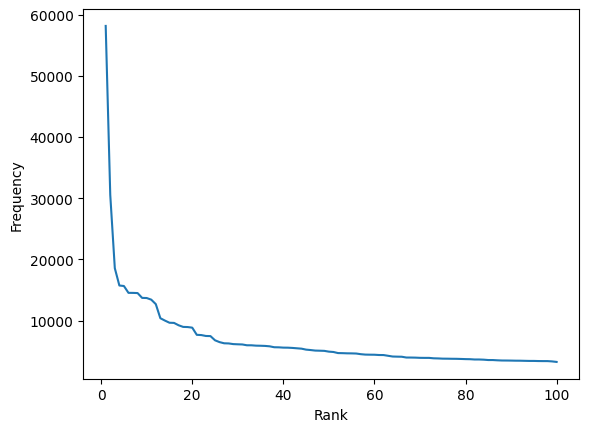

In [99]:
# Задание 1
# На основе подсчета частоты слов в корпусе проверьте выполнение закона Ципфа путем построения графика зависимости частоты слова от ранга.

# Закон Ципфа утверждает, что в любом естественном языке наиболее часто встречающееся слово встречается в текстах примерно в два раза чаще,
# чем второе наиболее часто встречающееся слово, третье наиболее часто встречающееся слово встречается примерно в три раза реже, чем самое часто встречающееся слово, и т.д.
import matplotlib.pyplot as plt

words = Counter()

for txt in banks['Preprocessed_texts']:
    words.update(txt)

# Сортировка слова по убыванию частоты
sorted_words = sorted(words.items(), key=lambda x: x[1], reverse=True)

#  График зависимости частоты слова от ранга
ranks = range(1, len(sorted_words) + 1)
frequencies = [word_count[1] for word_count in sorted_words]
plt.plot(ranks[:100], frequencies[:100])
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.show()

На полученном графике можно увидеть, как частота слов убывает с увеличением их ранга. Если график приблизительно соответствует гиперболе, то можно говорить о том, что закон Ципфа выполняется в данном корпусе.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from collections import Counter

In [26]:
random_state = 42

In [27]:
mapping = {'Negative': 0, 'Positive': 1}

In [28]:
banks.replace({'Score': mapping}, inplace=True)

In [29]:
banks

Score                                               Text  \
idx                                                               
0          1  В Альфа-Банке работает замечательная девушка -...   
1          0  Оформляя рассрочку в м. Видео в меге тёплый ст...   
2          1  Очень порадовала оперативность работы в банке....   
3          0  Имела неосторожность оформить потреб. кредит в...   
4          0  Небольшая предыстория: Нашел на сайте MDM банк...   
...      ...                                                ...   
13994      1  О высокой надёжности МКБ, порядочности и добро...   
13995      1  Обслуживаюсь в офисе на Чернореченской 42а, ка...   
13996      1  Попала сегодня в очень неприятную ситуацию. Ре...   
13997      1  Добрый день! Давно являюсь клиентом банка Русс...   
13998      0  Сначала было все банально. Взял в кредит mp3 п...   

                                      Preprocessed_texts  
idx                                                       
0      [альфа-банк, работать, замечательный, девушка,...  
1      [оформлять, рассрочка, м., видео, мег, тёплый,...  
2      [очень, порадовать, оперативность, работа, бан...  
3      [иметь, неосторожность, оформить, потреба, кре...  
4      [небольшой, предыстория, найти, сайт, mdm, бан...  
...                                                  ...  
13994  [высокий, надёжность, мкб, порядочность, добро...  
13995  [обслуживаться, офис, чернореченский, 42а, физ...  
13996  [попасть, сегодня, очень, неприятный, ситуация...  
13997  [добрый, день, давно, являться, клиент, банк, ...  
13998  [сначала, банально, взять, кредит, mp3, плеер,...  

[13999 rows x 3 columns]

In [30]:
train, test = train_test_split(banks, test_size=0.2, random_state=random_state)

In [31]:
train

Score                                               Text  \
idx                                                               
11755      0  23.01.2016 был произведен возврат средств за б...   
3710       0  Добрый день! Уже второй раз по моей банковской...   
3571       1  Добрый день!Хочу выразить огромную благодарнос...   
6926       1  Так вышло, что понадобилось обратиться за доку...   
6224       0  Приехали с женой на заключение сделки к назнач...   
...      ...                                                ...   
5191       0  Неделю назад при открытии вклада (открывал с ц...   
13418      1  Несмотря на глобальные издевательства Сбербанк...   
5390       0  7 февраля 2011 года моя жена, Федотова Оксана ...   
860        0  Хочу написать об отвратительной работе связки ...   
7270       0  Здравствуйте! В 2016 году, решил завести себе ...   

                                      Preprocessed_texts  
idx                                                       
11755  [23.01.2016, произвести, возврат, средство, би...  
3710   [добрый, день, второй, мой, банковский, карта,...  
3571   [добрый, день, хотеть, выразить, огромный, бла...  
6926   [выйти, понадобиться, обратиться, документальн...  
6224   [приехать, жена, заключение, сделка, назначить...  
...                                                  ...  
5191   [неделя, назад, открытие, вклад, открывать, це...  
13418  [несмотря, глобальный, издевательство, сбербан...  
5390   [7, февраль, 2011, год, жена, федотов, оксана,...  
860    [хотеть, написать, отвратительный, работа, свя...  
7270   [здравствуйте, 2016, год, решить, завести, деб...  

[11199 rows x 3 columns]

In [32]:
test

Score                                               Text  \
idx                                                               
2900       0  Ранее уже Вам писала о том, что мне наглым обр...   
3143       1  Уже более года назад делал вклад в Ренессанс К...   
8231       1  Писал несколько положительных отзывов об этом ...   
3855       0  Мы не клиенты, однако, жутко возмущены работой...   
8045       1  У моей бабушки недавно был юбилей. Я подумал, ...   
...      ...                                                ...   
5130       0  Среди заявленных услуг, которыми можно восполь...   
9657       0  Являюсь клиентом АО «БИНБАНК кредитные карты. ...   
11667      0  Отвратительно. 21.01.2016 19:38 (четверг) я оф...   
12064      1  День Добрый! Побывал в офисе Альфы (Братиславс...   
10479      0  Закончился срок вклада, за неделю заказал день...   

                                      Preprocessed_texts  
idx                                                       
2900   [ранее, писать, наглый, образ, всучить, страхо...  
3143   [год, назад, делать, вклад, ренессанс, кредит,...  
8231   [писать, несколько, положительный, отзыв, банк...  
3855   [клиент, однако, жутко, возмутить, работа, бан...  
8045   [мой, бабушка, недавно, юбилей, подумать, тако...  
...                                                  ...  
5130   [среди, заявить, услуга, который, воспользоват...  
9657   [являться, клиент, ао, бинбанк, кредитный, кар...  
11667  [отвратительный, 21.01.2016, 19:38, четверг, о...  
12064  [день, добрый, побывать, офис, альф, братислав...  
10479  [закончиться, срок, вклад, неделя, заказать, д...  

[2800 rows x 3 columns]

In [33]:
# Задание 3
# Постройте векторное представление текстов корпуса на основе метода TF*IDF (TfidfVectorizer).
# Используйте это представление текстов для обучения классификатора.
# Сравните его работу по сравнению с классификатором, использоваавшем модель Bag of Words (Мешка слов).
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

text_transformer = TfidfVectorizer()

X_train_text = text_transformer.fit_transform(train['Text'])
X_test_text = text_transformer.transform(test['Text'])

In [34]:
logit = LogisticRegression()
logit.fit(X_train_text, train['Score'])

LogisticRegression()

In [35]:
logit.score(X_test_text, test['Score'])

0.9425

## Создаем словарь, упорядоченный по частоте

В словаре будем использовать 2 специальных кода:
- Код заполнитель: 0
- Неизвестное слово: 1

Нумерация слов в словаре начинается с 2.

In [36]:
# Словарь, отображающий слова в коды
word_to_index = dict()
# Словарь, отображающий коды в слова
index_to_word = dict()

Максимальное количество обрабатываемых слов

In [37]:
max_words = 10000

Создаем словари

In [38]:
for i, word in enumerate(words.most_common(max_words - 2)):
    word_to_index[word[0]] = i + 2
    index_to_word[i + 2] = word[0]

In [39]:
word_to_index

{'банк': 2,
 'карта': 3,
 'это': 4,
 'день': 5,
 'мой': 6,
 'сотрудник': 7,
 'который': 8,
 'кредит': 9,
 'деньга': 10,
 'счёт': 11,
 'отделение': 12,
 'клиент': 13,
 'год': 14,
 'сказать': 15,
 'вопрос': 16,
 'свой': 17,
 'очень': 18,
 'время': 19,
 'сумма': 20,
 'кредитный': 21,
 'мочь': 22,
 'получить': 23,
 'офис': 24,
 'такой': 25,
 'проблема': 26,
 'заявление': 27,
 'договор': 28,
 'работа': 29,
 'платёж': 30,
 'банкомат': 31,
 'телефон': 32,
 'позвонить': 33,
 'месяц': 34,
 'документ': 35,
 'дать': 36,
 'ответ': 37,
 'решить': 38,
 'хотеть': 39,
 'обслуживание': 40,
 'звонить': 41,
 'ваш': 42,
 'работать': 43,
 'услуга': 44,
 'претензия': 45,
 'прийти': 46,
 'вклад': 47,
 'другой': 48,
 'звонок': 49,
 'номер': 50,
 'написать': 51,
 'один': 52,
 'ситуация': 53,
 'рубль': 54,
 'человек': 55,
 'минута': 56,
 'сделать': 57,
 'просто': 58,
 'говорить': 59,
 'средство': 60,
 'быть': 61,
 'альфа-банк': 62,
 'заявка': 63,
 'весь': 64,
 'срок': 65,
 'очередь': 66,
 '2': 67,
 'первый': 68

In [40]:
index_to_word

{2: 'банк',
 3: 'карта',
 4: 'это',
 5: 'день',
 6: 'мой',
 7: 'сотрудник',
 8: 'который',
 9: 'кредит',
 10: 'деньга',
 11: 'счёт',
 12: 'отделение',
 13: 'клиент',
 14: 'год',
 15: 'сказать',
 16: 'вопрос',
 17: 'свой',
 18: 'очень',
 19: 'время',
 20: 'сумма',
 21: 'кредитный',
 22: 'мочь',
 23: 'получить',
 24: 'офис',
 25: 'такой',
 26: 'проблема',
 27: 'заявление',
 28: 'договор',
 29: 'работа',
 30: 'платёж',
 31: 'банкомат',
 32: 'телефон',
 33: 'позвонить',
 34: 'месяц',
 35: 'документ',
 36: 'дать',
 37: 'ответ',
 38: 'решить',
 39: 'хотеть',
 40: 'обслуживание',
 41: 'звонить',
 42: 'ваш',
 43: 'работать',
 44: 'услуга',
 45: 'претензия',
 46: 'прийти',
 47: 'вклад',
 48: 'другой',
 49: 'звонок',
 50: 'номер',
 51: 'написать',
 52: 'один',
 53: 'ситуация',
 54: 'рубль',
 55: 'человек',
 56: 'минута',
 57: 'сделать',
 58: 'просто',
 59: 'говорить',
 60: 'средство',
 61: 'быть',
 62: 'альфа-банк',
 63: 'заявка',
 64: 'весь',
 65: 'срок',
 66: 'очередь',
 67: '2',
 68: 'первый'

## Преобразуем слова в коды

Функция для преобразования списка слов в список кодов

In [41]:
def text_to_sequence(txt, word_to_index):
    seq = []
    for word in txt:
        index = word_to_index.get(word, 1) # 1 означает неизвестное слово
        # Неизвестные слова не добавляем в выходную последовательность
        if index != 1:
            seq.append(index)
    return seq

In [42]:
txt = banks['Preprocessed_texts'][0]

In [43]:
seq = text_to_sequence(txt, word_to_index)

In [44]:
seq

[62,
 43,
 916,
 78,
 204,
 1866,
 357,
 2711,
 409,
 13,
 154,
 2380,
 1232,
 5,
 146,
 5,
 575,
 19,
 6,
 1951,
 161,
 72,
 9,
 298,
 54,
 46,
 1182,
 1840,
 23,
 9,
 953,
 90,
 1439,
 101,
 161,
 185,
 2241,
 20,
 5,
 4,
 6875,
 270,
 1770,
 218,
 299,
 490,
 213,
 1042,
 258,
 103,
 361,
 4,
 12,
 78,
 241,
 25,
 916,
 101,
 3279,
 292,
 1495,
 138,
 1420,
 62,
 61]

In [45]:
index_to_word[916]

'замечательный'

In [46]:
seq = [word_to_index.get(word, 1) for word in txt]

In [47]:
seq

[62,
 43,
 916,
 78,
 1,
 1,
 204,
 1866,
 357,
 2711,
 409,
 13,
 154,
 2380,
 1232,
 5,
 146,
 5,
 575,
 19,
 6,
 1951,
 161,
 72,
 9,
 298,
 1,
 54,
 46,
 1182,
 1840,
 23,
 9,
 953,
 90,
 1439,
 101,
 1,
 1,
 161,
 185,
 2241,
 20,
 5,
 4,
 6875,
 270,
 1770,
 218,
 299,
 490,
 213,
 1042,
 258,
 103,
 361,
 4,
 12,
 78,
 241,
 25,
 916,
 101,
 3279,
 292,
 1495,
 138,
 1420,
 62,
 61]

Преобразуем все тексты в последовательность кодов слов

In [48]:
banks['Sequences'] = banks.apply(lambda row: text_to_sequence(row['Preprocessed_texts'], word_to_index), axis=1)

In [49]:
banks

Score                                               Text  \
idx                                                               
0          1  В Альфа-Банке работает замечательная девушка -...   
1          0  Оформляя рассрочку в м. Видео в меге тёплый ст...   
2          1  Очень порадовала оперативность работы в банке....   
3          0  Имела неосторожность оформить потреб. кредит в...   
4          0  Небольшая предыстория: Нашел на сайте MDM банк...   
...      ...                                                ...   
13994      1  О высокой надёжности МКБ, порядочности и добро...   
13995      1  Обслуживаюсь в офисе на Чернореченской 42а, ка...   
13996      1  Попала сегодня в очень неприятную ситуацию. Ре...   
13997      1  Добрый день! Давно являюсь клиентом банка Русс...   
13998      0  Сначала было все банально. Взял в кредит mp3 п...   

                                      Preprocessed_texts  \
idx                                                        
0      [альфа-банк, работать, замечательный, девушка,...   
1      [оформлять, рассрочка, м., видео, мег, тёплый,...   
2      [очень, порадовать, оперативность, работа, бан...   
3      [иметь, неосторожность, оформить, потреба, кре...   
4      [небольшой, предыстория, найти, сайт, mdm, бан...   
...                                                  ...   
13994  [высокий, надёжность, мкб, порядочность, добро...   
13995  [обслуживаться, офис, чернореченский, 42а, физ...   
13996  [попасть, сегодня, очень, неприятный, ситуация...   
13997  [добрый, день, давно, являться, клиент, банк, ...   
13998  [сначала, банально, взять, кредит, mp3, плеер,...   

                                               Sequences  
idx                                                       
0      [62, 43, 916, 78, 204, 1866, 357, 2711, 409, 1...  
1      [267, 855, 1178, 3215, 3892, 2982, 7347, 171, ...  
2      [18, 1055, 910, 29, 2, 475, 183, 3, 628, 1767,...  
3      [118, 4818, 72, 2368, 9, 62, 18, 2665, 1287, 3...  
4      [418, 3851, 275, 87, 2, 648, 3, 4894, 2, 296, ...  
...                                                  ...  
13994  [401, 2321, 809, 5028, 8159, 7, 3099, 126, 441...  
13995  [362, 24, 9495, 2152, 201, 14, 24, 95, 141, 66...  
13996  [517, 109, 18, 992, 53, 38, 224, 233, 3, 46, 3...  
13997  [181, 5, 397, 86, 13, 2, 674, 691, 118, 343, 3...  
13998  [438, 4111, 127, 9, 460, 2037, 202, 660, 3984,...  

[13999 rows x 4 columns]

In [50]:
banks['Text'][2]

'Очень порадовала оперативность работы в банке. Заказал через интернет карту visa classic, потребовалось подойти в банк для подписания заявления. В тот же день мне открыли текущий счет с доступом через интернет по услуге Альфа-клик, а в течении недели я должен был получить карту. Наученный Сбербанком ожидать обещанное, я удивился, когда карта и правда пришла вовремя, при этом выдали мне ее минут за 5, что опять же очень порадовало. Да и операторы Воронежского отделения на пр-те Революции оказались очень добродушными, проконсультировали по всем ситуациям, о которых я уточнял.После этого я захотел подключить услугу Альфа-мобайл, для управления счетом через телефон, но забыл свой логин. Позвонив по горячей линии, девушка мне подсказала и логин, и подключила услугу (без обращения в банк), выслала в sms ссылку на приложение, то есть сервис был на должном уровне!В настоящий момент я являюсь клиентом Московского индустриального банка, ВТБ 24 и Сбербанка, сотрудничество с последними 2мя полнос

In [51]:
banks['Preprocessed_texts'][2]

['очень',
 'порадовать',
 'оперативность',
 'работа',
 'банк',
 'заказать',
 'интернет',
 'карта',
 'visa',
 'classic',
 'потребоваться',
 'подойти',
 'банк',
 'подписание',
 'заявление',
 'день',
 'открыть',
 'текущий',
 'счёт',
 'доступ',
 'интернет',
 'услуга',
 'альфа-клик',
 'течение',
 'неделя',
 'должный',
 'получить',
 'карта',
 'научить',
 'сбербанк',
 'ожидать',
 'обещать',
 'удивиться',
 'карта',
 'правда',
 'прийти',
 'вовремя',
 'выдать',
 'минута',
 '5',
 'очень',
 'порадовать',
 'оператор',
 'воронежский',
 'отделение',
 'пр-тот',
 'революция',
 'оказаться',
 'очень',
 'добродушный',
 'проконсультировать',
 'весь',
 'ситуация',
 'который',
 'уточнял.после',
 'захотеть',
 'подключить',
 'услуга',
 'альфа-мобайл',
 'управление',
 'счёт',
 'телефон',
 'забыть',
 'свой',
 'логин',
 'позвонить',
 'горячий',
 'линия',
 'девушка',
 'подсказать',
 'логин',
 'подключить',
 'услуга',
 'обращение',
 'банк',
 'выслать',
 'sms',
 'ссылка',
 'приложение',
 'сервис',
 'должный',
 'уров

In [52]:
banks['Sequences'][2]

[18,
 1055,
 910,
 29,
 2,
 475,
 183,
 3,
 628,
 1767,
 1215,
 416,
 2,
 861,
 27,
 5,
 120,
 415,
 11,
 792,
 183,
 44,
 894,
 107,
 104,
 73,
 23,
 3,
 2426,
 143,
 536,
 289,
 1315,
 3,
 385,
 46,
 693,
 136,
 56,
 119,
 18,
 1055,
 92,
 6453,
 12,
 4599,
 6653,
 145,
 18,
 6454,
 1479,
 64,
 53,
 8,
 1395,
 365,
 44,
 3364,
 1712,
 11,
 32,
 493,
 17,
 1517,
 33,
 164,
 132,
 78,
 1030,
 1517,
 365,
 44,
 117,
 2,
 1227,
 1163,
 1390,
 763,
 302,
 73,
 458,
 789,
 113,
 86,
 13,
 631,
 7348,
 2,
 1676,
 909,
 143,
 587,
 173,
 423,
 2196,
 4,
 48,
 169,
 443,
 191,
 620,
 4,
 3438,
 981,
 2936,
 12,
 2,
 126,
 2864,
 4599,
 6653,
 9830]

# Определение тональности отзывов на банки с помощью классических алгоритмов машинного обучения 

Используем логистическую регрессию и мешок слов.

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from collections import Counter

Константы

In [54]:
random_state = 42

## Готовим данные для обучения

Преобразуем текстовые метки классов в числовые

In [55]:
mapping = {'Negative': 0, 'Positive': 1}

In [56]:
banks.replace({'Score': mapping}, inplace=True)

In [57]:
banks

Score                                               Text  \
idx                                                               
0          1  В Альфа-Банке работает замечательная девушка -...   
1          0  Оформляя рассрочку в м. Видео в меге тёплый ст...   
2          1  Очень порадовала оперативность работы в банке....   
3          0  Имела неосторожность оформить потреб. кредит в...   
4          0  Небольшая предыстория: Нашел на сайте MDM банк...   
...      ...                                                ...   
13994      1  О высокой надёжности МКБ, порядочности и добро...   
13995      1  Обслуживаюсь в офисе на Чернореченской 42а, ка...   
13996      1  Попала сегодня в очень неприятную ситуацию. Ре...   
13997      1  Добрый день! Давно являюсь клиентом банка Русс...   
13998      0  Сначала было все банально. Взял в кредит mp3 п...   

                                      Preprocessed_texts  \
idx                                                        
0      [альфа-банк, работать, замечательный, девушка,...   
1      [оформлять, рассрочка, м., видео, мег, тёплый,...   
2      [очень, порадовать, оперативность, работа, бан...   
3      [иметь, неосторожность, оформить, потреба, кре...   
4      [небольшой, предыстория, найти, сайт, mdm, бан...   
...                                                  ...   
13994  [высокий, надёжность, мкб, порядочность, добро...   
13995  [обслуживаться, офис, чернореченский, 42а, физ...   
13996  [попасть, сегодня, очень, неприятный, ситуация...   
13997  [добрый, день, давно, являться, клиент, банк, ...   
13998  [сначала, банально, взять, кредит, mp3, плеер,...   

                                               Sequences  
idx                                                       
0      [62, 43, 916, 78, 204, 1866, 357, 2711, 409, 1...  
1      [267, 855, 1178, 3215, 3892, 2982, 7347, 171, ...  
2      [18, 1055, 910, 29, 2, 475, 183, 3, 628, 1767,...  
3      [118, 4818, 72, 2368, 9, 62, 18, 2665, 1287, 3...  
4      [418, 3851, 275, 87, 2, 648, 3, 4894, 2, 296, ...  
...                                                  ...  
13994  [401, 2321, 809, 5028, 8159, 7, 3099, 126, 441...  
13995  [362, 24, 9495, 2152, 201, 14, 24, 95, 141, 66...  
13996  [517, 109, 18, 992, 53, 38, 224, 233, 3, 46, 3...  
13997  [181, 5, 397, 86, 13, 2, 674, 691, 118, 343, 3...  
13998  [438, 4111, 127, 9, 460, 2037, 202, 660, 3984,...  

[13999 rows x 4 columns]

### Выделяем данные для обучения и тестирования

In [58]:
train, test = train_test_split(banks, test_size=0.2)

In [59]:
train

Score                                               Text  \
idx                                                               
12634      0  В начале июня в магазинах были произведены воз...   
13460      0  Мне не начислили бонусы 10% за покупки в январ...   
6015       0  Имел вклад в банке, у которого ЦБ РФ в марте 2...   
964        1  Добрый день! Я уже в рамках данного проекта вы...   
10928      0  Здравствуйте. В городе Ульяновске, в ДОЗаволжс...   
...      ...                                                ...   
1678       0  Я являлась клиентом банка Европлан, переименов...   
9169       1  Являюсь клиентом Сити уже 2 года. Сначала взял...   
12395      1  Я и вся моя семья являемся клиентами банка с 2...   
834        1  При всех своих недостатках Сити имеет некий на...   
582        1  Обращался в ДельтаКредит с целью оформить ипот...   

                                      Preprocessed_texts  \
idx                                                        
12634  [начало, июнь, магазин, произвести, возврат, п...   
13460  [начислить, бонус, 10, %, покупка, январь, дек...   
6015   [иметь, вклад, банк, который, цб, рф, март, 20...   
964    [добрый, день, рамка, данный, проект, высказыв...   
10928  [здравствуйте, город, ульяновск, дозаволжский,...   
...                                                  ...   
1678   [являться, клиент, банк, европлан, переименова...   
9169   [являться, клиент, сити, 2, год, сначала, взят...   
12395  [весь, семья, являться, клиент, банк, 2008, го...   
834    [свой, недостаток, сити, иметь, некий, набор, ...   
582    [обращаться, дельтакредит, цель, оформить, ипо...   

                                               Sequences  
idx                                                       
12634  [284, 486, 264, 804, 317, 199, 193, 21, 3, 245...  
13460  [520, 598, 124, 83, 199, 434, 318, 717, 361, 7...  
6015   [118, 47, 2, 8, 1004, 543, 321, 558, 126, 2818...  
964    [181, 5, 1212, 79, 989, 1707, 52, 131, 2, 1201...  
10928  [525, 291, 5572, 68, 269, 410, 635, 14, 90, 78...  
...                                                  ...  
1678   [86, 13, 2, 3273, 286, 3077, 510, 7133, 1553, ...  
9169   [86, 13, 1095, 67, 14, 438, 127, 9, 72, 21, 3,...  
12395  [64, 955, 86, 13, 2, 1298, 14, 1333, 635, 14, ...  
834    [17, 1869, 1095, 118, 984, 2618, 3392, 44, 8, ...  
582    [228, 1347, 540, 72, 453, 1143, 603, 3393, 4, ...  

[11199 rows x 4 columns]

In [60]:
test

Score                                               Text  \
idx                                                               
5057       0  И такое мнение сложилось даже не из-за процент...   
8880       0  Взял в кредит товар в магазине, при оформлении...   
6256       1  Внесли сестре, живущей в Питере, на счет прили...   
2720       0  Кассовый работник Ш-ва М.В. не умеет общаться ...   
10470      1  Добрый вечер, являюсь вкладчиком данного банка...   
...      ...                                                ...   
10516      1  4 года назад брала кредит в этом банке на Сиби...   
9532       0  У меня срок действия карты закончился в феврал...   
569        0  Сегодня около 13:15 посетил офис, расположенны...   
12610      1  Добрый день!Хочу поблагодарить за оперативност...   
2459       0  Снимала 06.01.2017 г. деньги со своей дебетово...   

                                      Preprocessed_texts  \
idx                                                        
5057   [такой, мнение, сложиться, из-за, процент, кре...   
8880   [взять, кредит, товар, магазин, оформление, де...   
6256   [внести, сестра, жить, питер, счёт, приличный,...   
2720   [кассовый, работник, ш-в, м.в, уметь, общаться...   
10470  [добрый, вечер, являться, вкладчик, данный, ба...   
...                                                  ...   
10516  [4, год, назад, брать, кредит, банк, сибирский...   
9532   [срок, действие, карта, закончиться, февраль, ...   
569    [сегодня, около, 13:15, посетить, офис, распол...   
12610  [добрый, день, хотеть, поблагодарить, оператив...   
2459   [снимать, 06.01.2017, г., деньга, свой, дебето...   

                                               Sequences  
idx                                                       
5057   [25, 731, 685, 261, 85, 21, 237, 40, 1151, 4, ...  
8880   [127, 9, 677, 264, 167, 78, 98, 1628, 246, 306...  
6256   [186, 2938, 673, 2018, 11, 1573, 20, 10, 1287,...  
2720   [2244, 391, 7765, 8297, 1261, 435, 13, 1813, 1...  
10470  [181, 686, 86, 933, 79, 2, 2515, 1375, 14, 441...  
...                                                  ...  
10516  [260, 14, 210, 170, 9, 2, 8304, 8267, 78, 123,...  
9532   [65, 254, 3, 616, 468, 33, 164, 132, 284, 34, ...  
569    [109, 200, 1106, 24, 1094, 1437, 6, 308, 570, ...  
12610  [181, 5, 39, 777, 910, 1329, 141, 1141, 90, 70...  
2459   [456, 126, 10, 17, 215, 3, 245, 31, 2975, 166,...  

[2800 rows x 4 columns]

### Разделяем метки классов и данные для обучения

Данные для обучения

In [61]:
x_train_seq = train['Sequences']
y_train = train['Score']

Данные для тестирования

In [62]:
x_test_seq = test['Sequences']
y_test = test['Score']

In [63]:
x_test_seq

idx
5057     [25, 731, 685, 261, 85, 21, 237, 40, 1151, 4, ...
8880     [127, 9, 677, 264, 167, 78, 98, 1628, 246, 306...
6256     [186, 2938, 673, 2018, 11, 1573, 20, 10, 1287,...
2720     [2244, 391, 7765, 8297, 1261, 435, 13, 1813, 1...
10470    [181, 686, 86, 933, 79, 2, 2515, 1375, 14, 441...
                               ...                        
10516    [260, 14, 210, 170, 9, 2, 8304, 8267, 78, 123,...
9532     [65, 254, 3, 616, 468, 33, 164, 132, 284, 34, ...
569      [109, 200, 1106, 24, 1094, 1437, 6, 308, 570, ...
12610    [181, 5, 39, 777, 910, 1329, 141, 1141, 90, 70...
2459     [456, 126, 10, 17, 215, 3, 245, 31, 2975, 166,...
Name: Sequences, Length: 2800, dtype: object

In [64]:
y_test

idx
5057     0
8880     0
6256     1
2720     0
10470    1
        ..
10516    1
9532     0
569      0
12610    1
2459     0
Name: Score, Length: 2800, dtype: int64

## Создаем мешок слов

In [65]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for index in sequence:
            results[i, index] += 1.
    return results

In [66]:
x_train = vectorize_sequences(x_train_seq, max_words)

In [67]:
x_test = vectorize_sequences(x_test_seq, max_words)

In [68]:
x_train[0][:100]

array([0., 0., 4., 2., 0., 2., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [69]:
len(x_train[0])

10000

## Создаем модель машинного обучения

In [70]:
lr = LogisticRegression(random_state=random_state, max_iter=500)

## Обучаем модель машинного обучения

In [71]:
lr.fit(x_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

## Оцениваем качество обучения на тестовом наборе данных

Определяем долю правильных ответов (accuracy) на тестовом наборе данных

In [73]:
lr.score(x_test, y_test)

0.9414285714285714

## Применяем модель для определения тональности отзыва на банк

**Позитивный отзыв**

In [74]:
positive_text = """Брал кредит в Мегабанке на автомобиль. Выдали за один день. Никаких скрытых комиссий и переплат. 
У банка удобное мобильное приложение, через которое можно быстро отправить ежемесячный платеж. 
Досрочное гасить начал через три месяца. Я доволен оперативностью и удобством. Огромное спасибо!
"""

Подготовка текста к обработке

In [75]:
positive_preprocessed_text = preprocess(positive_text, stop_words, punctuation_marks, morph)

In [76]:
positive_preprocessed_text

['брать',
 'кредит',
 'мегабанк',
 'автомобиль',
 'выдать',
 'день',
 'никакой',
 'скрытый',
 'комиссия',
 'переплата',
 'банк',
 'удобный',
 'мобильный',
 'приложение',
 'который',
 'быстро',
 'отправить',
 'ежемесячный',
 'платёж',
 'досрочный',
 'гасить',
 'начать',
 'месяц',
 'довольный',
 'оперативность',
 'удобство',
 'огромный',
 'спасибо']

In [77]:
positive_seq = text_to_sequence(positive_preprocessed_text, word_to_index)

In [78]:
positive_seq

[170,
 9,
 963,
 136,
 5,
 81,
 1890,
 80,
 1028,
 2,
 287,
 305,
 763,
 8,
 128,
 205,
 489,
 30,
 358,
 1422,
 279,
 34,
 299,
 910,
 1316,
 312,
 75]

In [79]:
positive_bow = vectorize_sequences([positive_seq], max_words)

In [80]:
positive_bow[0][0:100]

array([0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Выполняем распознавание

In [81]:
result = lr.predict(positive_bow)

In [82]:
result

array([1])

**Негативный отзыв**

In [83]:
negative_text = """Взял кредит в ТакСебеБанке на автомобиль. В договор включили обязательный контракт
на помощь на дороге, который мне не нужен. Узнал об этом только во время подписания договора, иначе бы отказался.
Альтернативы была страхование жизни, но мне это даже не предложили. Скорее всего, менеджер продвигает
продажи услуг этой компании в ущерб интересов клиента. Как минимум, непорядочно и непрофессионально.
У банка ужасное мобильное приложение, из-за которого с меня взяли штраф 10 тыс.руб. По требованиям 
банка после покупки автомобиля в приложении нужно загрузить ПТС. Я загрузил и проверил, что ПТС в приложении есть.
Но через некоторое время ПТС из приложения пропал и с меня взяли штраф. Никому не рекомендую связываться с ТакСебеБанком.
"""

In [84]:
negative_preprocessed_text = preprocess(negative_text, stop_words, punctuation_marks, morph)
negative_seq = text_to_sequence(negative_preprocessed_text, word_to_index)
negative_bow = vectorize_sequences([negative_seq], max_words)

In [85]:
negative_bow[0][0:100]

array([0., 0., 2., 0., 2., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [86]:
result = lr.predict(negative_bow)

In [87]:
result

array([0])

In [88]:
result = lr.predict_proba(negative_bow)

In [89]:
result

array([[0.98368517, 0.01631483]])

#Облако слов (WordCloud)

In [72]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

stops = set(stopwords.words('russian'))

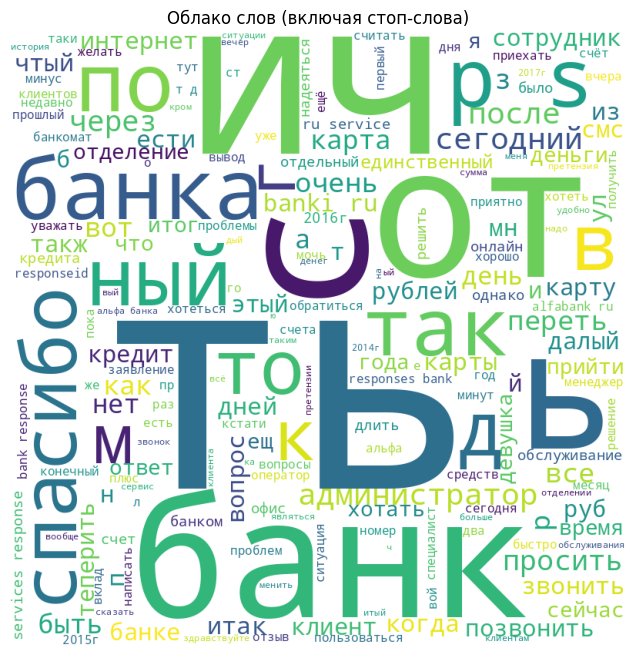

In [90]:
text = ' '.join(words)

wordcloud = WordCloud(
    background_color ='white',
    width = 800,
    height = 800, 
).generate(text)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title('Облако слов (включая стоп-слова)')
plt.show()

In [91]:
# Задание 2
# Посмотрите, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud). 
# Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.
# Исправьте приведенный пример для представления Bag of Words (Мешок слов).
# Создайте словарь частот слов с помощью collections.Counter
# Нарисуйте облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()
# Используйте nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

In [102]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

{'тот', 'перед', 'с', 'там', 'я', 'она', 'до', 'эту', 'более', 'из', 'тем', 'чем', 'нет', 'себе', 'впрочем', 'наконец', 'как', 'не', 'другой', 'тоже', 'раз', 'хоть', 'сейчас', 'а', 'всего', 'за', 'они', 'так', 'эти', 'ж', 'ничего', 'или', 'что', 'тебя', 'того', 'конечно', 'ведь', 'лучше', 'он', 'вас', 'быть', 'только', 'ее', 'надо', 'всю', 'над', 'свою', 'если', 'мы', 'еще', 'такой', 'кто', 'этого', 'опять', 'много', 'будто', 'какой', 'всех', 'после', 'про', 'чтобы', 'для', 'от', 'у', 'через', 'на', 'по', 'нибудь', 'без', 'нас', 'к', 'их', 'его', 'но', 'зачем', 'была', 'чуть', 'вам', 'мне', 'ты', 'ни', 'бы', 'да', 'и', 'моя', 'хорошо', 'уж', 'этой', 'был', 'меня', 'куда', 'вы', 'разве', 'три', 'всегда', 'же', 'между', 'когда', 'под', 'никогда', 'мой', 'чего', 'этот', 'теперь', 'вот', 'ну', 'нее', 'ней', 'то', 'уже', 'потому', 'совсем', 'здесь', 'один', 'том', 'почти', 'него', 'есть', 'вдруг', 'них', 'ему', 'больше', 'все', 'два', 'тут', 'этом', 'им', 'может', 'будет', 'ей', 'ли', 'можн

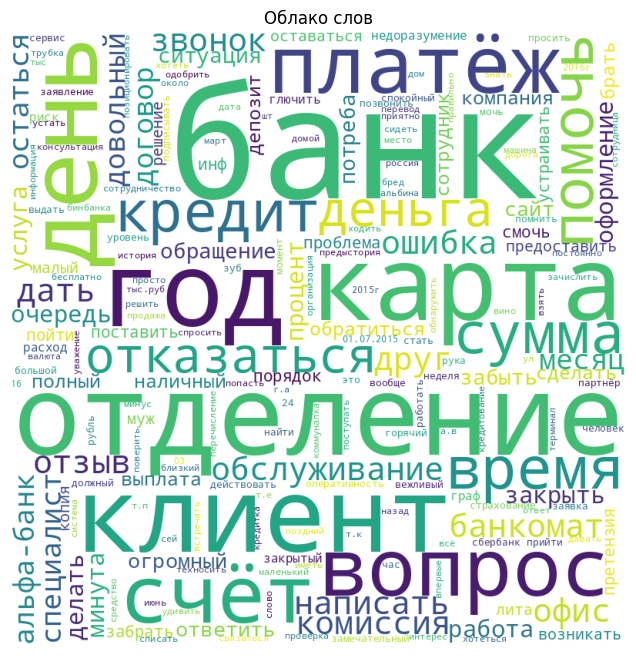

In [108]:
stops = set(stopwords.words('russian'))
print(stops)

tokens = [morph.parse(token)[0].normal_form for token in word_tokenize(text.lower()) if token not in stops and token not in punctuation_marks and token not in '\'"']
frequencies = Counter(tokens)
print(frequencies)

wordcloud = WordCloud(
    background_color ='white',
    width = 800,
    height = 800, 
).generate_from_frequencies(frequencies)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title('Облако слов')
plt.show()